In [1]:
from pathlib import Path
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.model_selection import train_test_split
import sqlalchemy
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
from data_access.load_file import load_table
from data_processing.functions import time_for_phase
from data_preparation import compute_work_item_times
from data_processing import features
from modeling.evaluation import train_test_predictions, plot_train_test

First we load the data and the features

In [2]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
times = time_for_phase(data)
total_times = compute_work_item_times(data)
work_times = features.work_times(times, time_col="duration_in_days")
work_frequency = features.work_times(times)
process_length = features.process_length(times)
is_open = features.is_open(data)

Then we load the outlier predicitions from notebook 6_outlier_prediction

In [3]:
# engine = sqlalchemy.create_engine("xxxxx")
# con = engine.connect()
# outliers = pd.read_sql_table("outlier_feature", con=con)
# outliers.drop(columns=["index"], inplace=True)
# outliers.rename(columns={"predictions": "outlier_pred"}, inplace=True)

In [4]:
normalize_cols = list(set(work_times.columns) - set(["work_item"]))
stats = work_times[normalize_cols].describe()
work_times[normalize_cols] = (work_times[normalize_cols]- stats.T["mean"]) / stats.T["std"]

In [5]:
work_times.fillna(0, inplace=True)

Now we can merge all of the dataframes together

In [6]:
final = reduce(lambda x, y: pd.merge(x, y, on="work_item", how="inner"), [work_times, work_frequency, process_length, is_open])

Now we add the other given features like domain, work_priority, work_type, ...

In [7]:
# final.drop_duplicates("work_item", inplace=True)
# final.set_index("work_item", inplace=True)
# cols_to_encode = ["domain", "work_priority", "work_type", "platform", "components"]
# encode = data[["work_item", *cols_to_encode]].drop_duplicates("work_item")
# encoded = pd.get_dummies(encode, columns=cols_to_encode)
# final = pd.merge(final, encoded, left_index=True, right_on="work_item").set_index("work_item")
# final.head()

In [8]:
final.drop_duplicates("work_item", inplace=True)
final.set_index("work_item", inplace=True)
final.head()

,Accept,Analyze,Build,Clarify,Deploy,Design,End,Package,Test,Accept_freq,Analyze_freq,Build_freq,Clarify_freq,Deploy_freq,Design_freq,End_freq,Package_freq,Test_freq,process_length,is_open
work_item,,,,,,,,,,,,,,,,,,,,
WI_000001,-0.236167,-0.273965,-0.072698,-0.011031,0.129078,-0.194485,0.0,0.232761,-0.086480,1,3,1,0,1,3,1,1,1,12,0
WI_000002,-0.276203,-0.212036,-0.203936,-0.011031,-0.291062,-0.197271,0.0,-0.092529,-0.150685,0,1,1,0,0,1,1,0,0,4,0
WI_000003,-0.276203,0.082569,-0.203936,-0.011031,-0.291062,-0.084511,0.0,-0.092529,-0.053270,0,2,1,0,0,2,1,1,1,8,0
WI_000004,-0.201591,-0.211858,-0.203936,-0.011031,0.420542,-0.197271,0.0,-0.092529,-0.150685,1,1,1,0,1,1,1,1,1,8,0
WI_000005,-0.274383,-0.088268,-0.181875,-0.011031,0.074017,-0.196780,0.0,-0.092529,-0.150685,1,1,2,0,1,2,1,0,0,8,0


Now the data is preprocessed and we can start splitting it into train and test dataset.

In [9]:
open_wis = is_open[is_open["is_open"]==1]["work_item"].values
times_open = final[final.index.isin(open_wis)]
times_closed = final[~final.index.isin(open_wis)]

In [10]:
x_data = times_closed
y_data = work_frequency[~work_frequency["work_item"].isin(open_wis)].set_index("work_item")
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

In [11]:
print("Train data shape = {}".format(x_train.shape))
print("Test data shape = {}".format(x_test.shape))

Train data shape = (7049, 20)
Test data shape = (3473, 20)


Let's build a model. Our goal is to predict the path for an open work item. So the output layer must have 9 neurons. The other layers are more or less randomly chosen.

In [12]:
model = keras.Sequential([
            keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[len(x_train.columns)]),
            keras.layers.Dense(9, activation=tf.nn.relu),
            keras.layers.Dense(9, activation=tf.nn.relu),
            keras.layers.Dense(9, activation=tf.nn.relu),
            keras.layers.Dense(9, activation=tf.nn.relu),
            keras.layers.Dense(9, activation=tf.nn.relu)
        ])

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

We train the model for 50 Epochs.

In [14]:
model.fit(x_train.values, y_train.values, epochs=50, verbose=False)

In [15]:
val = 2

Predictions for the columns value Build_freq


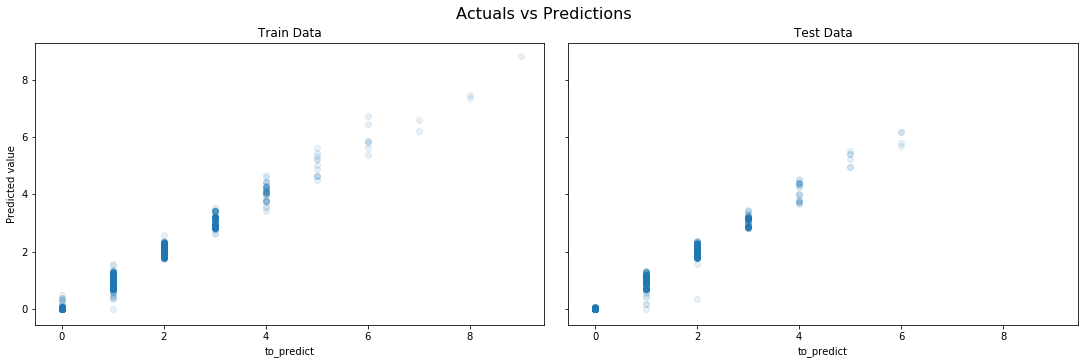

In [16]:
print("Predictions for the columns value {}".format(y_train.columns[val]))
train_predictions, test_predictions = train_test_predictions(x_train, x_test, model, val=val)
plot_train_test(train_predictions, y_train, test_predictions, y_test, col=y_train.columns[val])

We can see, that predictions work quite well. So we're going to write this into a function and use this to train our model.

In [17]:
predict_df = times_open
submit_predictions = pd.DataFrame(predict_df.index)

In [18]:
for i in range(len(y_train.columns)):
    submit_predictions[y_train.columns[i]] = model.predict(predict_df.values)[:, i]

In [19]:
submit_predictions.describe()

,Accept_freq,Analyze_freq,Build_freq,Clarify_freq,Deploy_freq,Design_freq,End_freq,Package_freq,Test_freq
count,1042.000000,1042.000000,1042.000000,1042.0,1042.000000,1042.000000,1042.000000,1042.000000,1042.0
mean,0.239409,1.154395,0.482129,0.0,0.209581,0.778405,1.007497,0.124857,0.0
std,0.534597,0.398833,0.761728,0.0,0.414055,0.773302,0.023729,0.384343,0.0
min,0.000000,0.913461,0.000000,0.0,0.000000,0.104094,0.597062,0.000000,0.0
25%,0.000000,0.995286,0.000000,0.0,0.000000,0.126684,1.002106,0.000000,0.0
50%,0.000000,1.040447,0.000000,0.0,0.000000,0.281287,1.009527,0.000000,0.0
75%,0.000000,1.072331,1.007211,0.0,0.000000,1.217481,1.015688,0.000000,0.0
max,4.880669,7.655483,5.058437,0.0,1.532163,4.878014,1.083673,3.079886,0.0


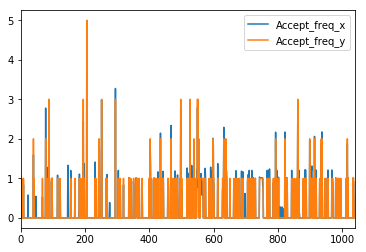

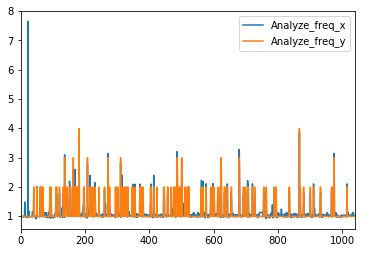

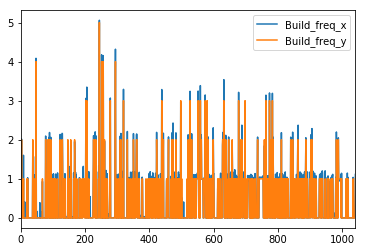

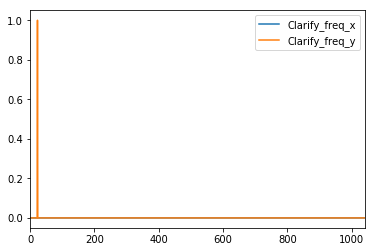

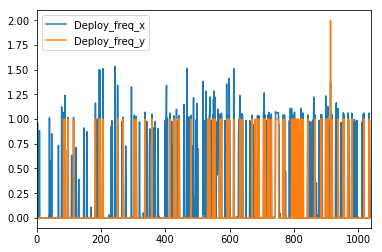

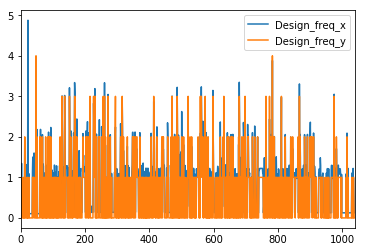

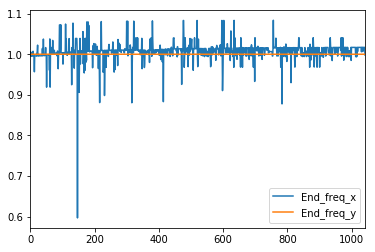

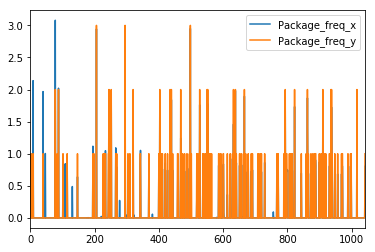

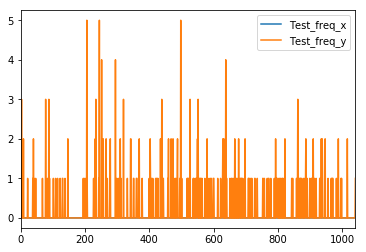

In [20]:
freq = work_frequency[work_frequency.work_item.isin(open_wis)]
merged = pd.merge(submit_predictions, freq, on="work_item")
freq_cols = ['Accept_freq', 'Analyze_freq', 'Build_freq', 'Clarify_freq', 'Deploy_freq', 'Design_freq', 'End_freq', 'Package_freq', 'Test_freq']
for col in freq_cols:
    merged[[col+"_x", col+"_y"]].plot()

In [21]:
submit_predictions.to_csv("../data/path_learning.csv", index=False)